# Few-Shot Learning Email Classification with Pre-Trained Word2Vec Embeddings

In [1]:
import pandas as pd
import numpy as np
from random import seed
from random import sample
from wordfile import func
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import gensim.downloader as api
from gensim.models.keyedvectors import Word2VecKeyedVectors
import joblib
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy import spatial
import os
import spacy

In [2]:
model = api.load('word2vec-google-news-300')

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
df = pd.read_csv("./emaildataset.csv", usecols = ['Subject','Body', 'Class'])
df.head()

,Subject,Body,Class
0,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending
1,Order for new Cheque book,"Good morning, I want to place an order for an ...",General
2,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing
3,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request
4,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending


In [4]:
nlp = spacy.load('en')

In [5]:
my_stop = ["'d", "'ll", "'m", "'re", "'s", "'ve",'a','cc','subject','http', 'gbp', 'usd', 'eur', 'inr', 'cad', 'thanks', "acc", "id", 'account', 'regards', 'hi', 'hello', 'thank you', 'greetings', 'about','above', 'across','after','afterwards','against','alone','along','already','also','although','am','among', 'amongst','amount','an','and','another','any','anyhow','anyone','anything','anyway','anywhere','are','around','as', 'at','be','became','because','become','becomes','becoming','been','before','beforehand','behind','being','below', 'beside','besides','between','both','bottom','but','by','ca','call','can','could','did', 'do', 'does', 'doing', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'every', 'everyone', 'everything', 'everywhere', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'further', 'get', 'give', 'go', 'had', 'has', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'i', 'if', 'in', 'indeed', 'into', 'is', 'it', 'its', 'itself', 'just', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'made', 'make', 'many', 'may', 'me', 'meanwhile', 'might', 'mine', 'more', 'moreover', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'nevertheless', 'next', 'nine', 'no', 'nobody', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'quite', 'rather', 're', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'under', 'unless', 'until', 'up', 'upon', 'us', 'used', 'using', 'various', 'very', 'via', 'was', 'we', 'well', 'were', 'whatever', 'whence', 'whenever', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'whoever', 'whole', 'whom', 'whose', 'will', 'with', 'within', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', '‘d', '‘ll', '‘m', '‘re', '‘s', '‘ve', '’d', '’ll', '’m', '’re', '’s', '’ve']


In [6]:
def get_only_chars(text):    
    text = text.replace("-", " ") #replace hyphens with spaces
    text = text.replace("\t", " ")
    text = text.replace("\n", " ")

    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    t = ""

    for i in text.lower().split():
        if func(i) is not None:
            t += func(i) + " "
        else :
            t += i + " "

    t = t.rstrip()
    
    text = " ".join([i for i in t.lower().split()])
    text = " ".join(token for token in text.split() if token not in my_stop)

    doc = nlp(text)
    
    normalized = " ".join(token.lemma_ for token in doc)
    
    doc = " ".join(token.orth_ for token in nlp(normalized) if not token.is_punct | token.is_space)
    return doc

In [7]:
print(get_only_chars("hi i want info on le 12234."))

want info legal entity


In [8]:
for i in range(df.shape[0]):
    # merge subject and body strings
    df['Text'] = (df['Subject'] + " " + df['Body'])

In [9]:
def converter(x):
    try:
        return ' '.join([x.lower() for x in str(x).split()])
    except AttributeError:
        return None  # or some other value

df['Text'] = df['Text'].apply(converter)

In [10]:
text_clean=[]

for i in range(df.shape[0]):
    text_clean.append(get_only_chars(df.loc[i]['Text']))

In [11]:
df['Text'] = df['Text'].apply(lambda x: get_only_chars(x))

In [15]:
df['Text'] = df['Text'].apply(lambda x: print(type(x)))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [12]:
df = df.drop_duplicates('Text')

In [13]:
df.shape

(354, 4)

In [14]:
df.sample(frac=1).reset_index(drop=True)

,Subject,Body,Class,Text
0,Incomplete transaction 036456,There has been only a partial payment of amoun...,Pending,incomplete transaction partial payment assurin...
1,Processing transaction having ID : 134746,This is in response to your email notifying ab...,Processing,process transaction have response email notify...
2,Payment outstanding for transaction 399192,"Since my transaction 399192 is still pending, ...",Pending,payment outstanding transaction transaction pe...
3,Payment outstanding for transaction 294356,The transaction 294356 is taking too long to c...,Pending,payment outstanding transaction transaction ta...
4,Request to send details of transaction 393689,Urgently require details of acc 393689 reply asap,Request,request send detail transaction urgently requi...
...,...,...,...,...
349,Urgently required update on transaction 648334,I request you to kindly send the status of my ...,Request,urgently require update transaction request ki...
350,Transaction 604411 is complete,Hello! Sincere greetings for the day. I would ...,Complete,transaction complete sincere day like inform t...
351,cannot take out money,This is to inform you that I am not able to wi...,General,can not money inform not able withdraw money help
352,Payment is pending for transaction 755447,There has been only a partial payment of amoun...,Pending,payment pende transaction partial payment assu...


In [291]:
# set the by default to:
num_classes = df.Class.unique() # the number of classes we consider (since the dataset has many classes)
sample_size = 2 # the number of labeled sampled we’ll require from the user

In [292]:
smallest_sample_size = min(df['Class'].value_counts())

In [293]:
# Generate samples that contains K samples of each class

def gen_sample(sample_size, num_classes):

    df_1 = df[(df["Class"] < num_classes+1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    
    train = df_1[df_1["Class"] == np.unique(df_1['Class'])[0]].sample(sample_size)
#     return train
    train_index = train.index.tolist()

    for i in range(1,num_classes):
        train_2 = df_1[df_1["Class"] == np.unique(df_1['Class'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())

    test = df_1[~df_1.index.isin(train_index)]
    return train, test

In [294]:
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

In [295]:
df['Class'] = df['Class'].apply(lambda x : x + 1)

In [297]:
# Text processing (split, find token id, get embedidng)
def transform_sentence(text, model):

    def preprocess_text(raw_text, model=model):

        raw_text = raw_text.split()
        return list(filter(lambda x: x in model.vocab, raw_text))

    tokens = preprocess_text(text)

    if not tokens:
        return np.zeros(model.vector_size)

    text_vector = np.mean(model[tokens], axis=0)

    return np.array(text_vector)

## Pre-trained Word2Vec and ML algorithms

In [298]:
# Install with below cell if you're not able to install on terminal

# import sys
# !{sys.executable} -m pip install xgboost

In [299]:
import xgboost

In [319]:
def return_score_xgb(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Class'].values
    X_test = test['Text']
    y_test = test['Class'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    # XG Boost
    clf = xgboost.XGBClassifier()
    clf.fit(X_train_mean, y_train)

    if not os.path.exists('./pkl_objects'):
        os.mkdir('./pkl_objects')
    
    joblib.dump(le, './pkl_objects/labelencoder.pkl')
    joblib.dump(clf, './pkl_objects/clf.pkl')

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

In [320]:
c = return_score_xgb(3, 2)
print(c)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
0.5106382978723404


## Comparison of accuracies

In [312]:
all_accuracy_xgb = {2:[],3:[],4:[],5:[],6:[],7:[]}

for num_samples in range(1, smallest_sample_size):

    for num_cl in range(2, 7):

        all_accuracy_xgb[num_cl].append(return_score_xgb(num_samples,num_cl))

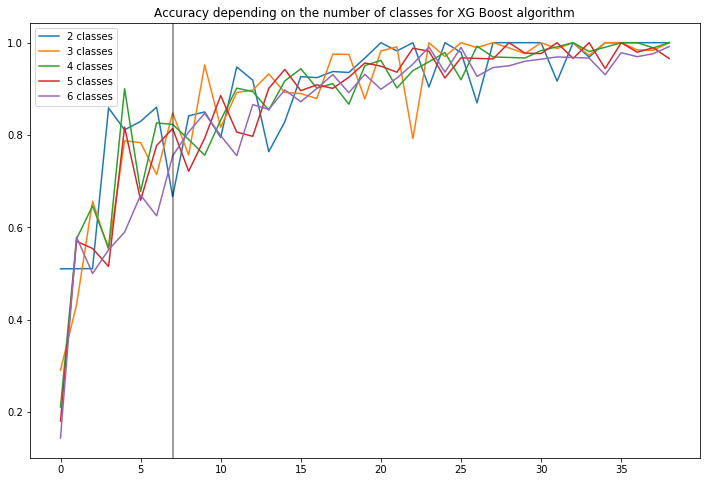

<Figure size 432x288 with 0 Axes>

In [313]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_xgb[2], label="2 classes")
plt.plot(all_accuracy_xgb[3], label="3 classes")
plt.plot(all_accuracy_xgb[4], label="4 classes")
plt.plot(all_accuracy_xgb[5], label="5 classes")
plt.plot(all_accuracy_xgb[6], label="6 classes")
plt.axvline(7, c='black', alpha=0.5)

plt.title("Accuracy depending on the number of classes for XG Boost algorithm")
plt.legend()
plt.show()
plt.savefig('accuracy_plot.jpg')

## Summary

In [314]:
df_results = pd.DataFrame({
    
    'Nb Classes':[2, 3, 4, 5, 6], 

    'mean XG Boost':[np.mean(all_accuracy_xgb[2]), 
        np.mean(all_accuracy_xgb[3]), 
        np.mean(all_accuracy_xgb[4]), 
        np.mean(all_accuracy_xgb[5]),
        np.mean(all_accuracy_xgb[6])],
    'max XG Boost':[max(all_accuracy_xgb[2]), 
        max(all_accuracy_xgb[3]), 
        max(all_accuracy_xgb[4]), 
        max(all_accuracy_xgb[5]),
        max(all_accuracy_xgb[6])]
    })

In [315]:
df_results

,Nb Classes,mean XG Boost,max XG Boost
0,2,0.892649,1.000000
1,3,0.882517,1.000000
2,4,0.877565,1.000000
3,5,0.866518,1.000000
4,6,0.845066,0.991667
